<h1>Programming Exercise 7: K-means Clustering and Principal Component Analysis</h1>
<h3>Introduction</h3>
In this exercise, we will implement the K-means clustering algorithm and apply it to compress an image. In the second part, we will use principle component analasys to find a low-dimensional representation of face images. To  begein we  import necessary libraries.

In [19]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Import regular expressions to process emails
import re

# Plotting library
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

from IPython.display import HTML, display, clear_output

try:
    pyplot.rcParams["animation.html"] = "jshtml"
except ValueError:
    pyplot.rcParams["animation.html"] = "html5"

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

%load_ext autoreload
%autoreload 2

from matplotlib.animation import FuncAnimation

# tells matplotlib to embed plots within the notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h3>1 K-means Clustering</h3>
In this exercise, we will implement the K-means algorithm and use it for image compression. We begin with an example 2D dataset that will help us gain an intuition of how the K-means algorithm works. After the, we will use K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common.

The algorithm works by, with an initial set of centroids, assigning each data point to its closest centroid. This will be accomplishes in the findClosestCentroids function.

In [20]:
def findClosestCentroids(X, centroids):
    """
    Computes the centroid memberships for every example.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        That is, we have m examples each of n dimensions.
        
    centroids : array_like
        The k-means centroids of size (K, n). K is the number
        of clusters, and n is the the data dimension.
    
    Returns
    -------
    idx : array_like
        A vector of size (m, ) which holds the centroids assignment for each
        example (row) in the dataset X.
    """
    K = centroids.shape[0]
    m = X.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)
    
    for i in range(m):
        tempX = X[i,:]
        tempSums = np.zeros(K)
        for j in range(K):
            tempCentroid = centroids[j,:]
            tempDiff = tempX - tempCentroid
            tempDiff = np.square(tempDiff)
            tempSums[j] = np.sum(tempDiff)
        idx[i] = np.argmin(tempSums)

    return idx

The following cell tests our code (we should see the closest centroids appear as [0 2 1])

In [21]:
# Load an example dataset that we will be using
data = loadmat(os.path.join('Data', 'ex7data2.mat'))
X = data['X']

# Select an initial set of centroids
K = 3   # 3 Centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

# Find the closest centroids for the examples using the initial_centroids
idx = findClosestCentroids(X, initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3])

Closest centroids for the first 3 examples:
[0 2 1]


The next step in the algorithm computes, for each centroid, the average of the points assigned to it. This will be accomplished in the computeCentroids function.

In [22]:
def computeCentroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the data points
    assigned to each centroid.
    
    Parameters
    ----------
    X : array_like
        The datset where each row is a single data point. That is, it 
        is a matrix of size (m, n) where there are m datapoints each
        having n dimensions. 
    
    idx : array_like 
        A vector (size m) of centroid assignments (i.e. each entry in range [0 ... K-1])
        for each example.
    
    K : int
        Number of clusters
    
    Returns
    -------
    centroids : array_like
        A matrix of size (K, n) where each row is the mean of the data 
        points assigned to it.
    """
    # Useful variables
    m, n = X.shape
    centroids = np.zeros((K, n))
    
    for i in range(K):
        # Find examples which fall into cluster k
        sel = np.argwhere(idx==i)
        centroids[i,:] = np.mean(X[sel,:], axis=0)

    return centroids

The following cell will test this function.

In [23]:
# Compute means based on the closest centroids found in the previous part.
centroids = computeCentroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)

Centroids computed after initial finding of closest centroids:
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


We now have all the pieces necessary to run the K-means algorithm, as all we do is repeat the last two steps for a set number of iterations. As we do so, the means will converge to the centers of any clusters in our dataset. 

In [24]:
def plotProgresskMeans(i, X, centroid_history, idx_history):
    """
    A helper function that displays the progress of k-Means as it is running. It is intended for use
    only with 2D data. It plots data points with colors assigned to each centroid. With the
    previous centroids, it also plots a line between the previous locations and current locations
    of the centroids.

    Parameters
    ----------
    i : int
        Current iteration number of k-means. Used for matplotlib animation function.

    X : array_like
        The dataset, which is a matrix (m x n). Note since the plot only supports 2D data, n should
        be equal to 2.

    centroid_history : list
        A list of computed centroids for all iteration.

    idx_history : list
        A list of computed assigned indices for all iterations.
    """
    K = centroid_history[0].shape[0]
    pyplot.gcf().clf()
    cmap = pyplot.cm.rainbow
    norm = mpl.colors.Normalize(vmin=0, vmax=2)

    for k in range(K):
        current = np.stack([c[k, :] for c in centroid_history[:i+1]], axis=0)
        pyplot.plot(current[:, 0], current[:, 1],
                    '-Xk',
                    mec='k',
                    lw=2,
                    ms=10,
                    mfc=cmap(norm(k)),
                    mew=2)

        pyplot.scatter(X[:, 0], X[:, 1],
                       c=idx_history[i],
                       cmap=cmap,
                       marker='o',
                       s=8**2,
                       linewidths=1,)
    pyplot.grid(False)
    pyplot.title('Iteration number %d' % (i+1))

In [25]:
def runkMeans(X, centroids, findClosestCentroids, computeCentroids,
              max_iters=10, plot_progress=False):
    """
    Runs the K-means algorithm.

    Parameters
    ----------
    X : array_like
        The data set of size (m, n). Each row of X is a single example of n dimensions. The
        data set is a total of m examples.

    centroids : array_like
        Initial centroid location for each clusters. This is a matrix of size (K, n). K is the total
        number of clusters and n is the dimensions of each data point.

    findClosestCentroids : func
        A function (implemented by student) reference which computes the cluster assignment for
        each example.

    computeCentroids : func
        A function(implemented by student) reference which computes the centroid of each cluster.

    max_iters : int, optional
        Specifies the total number of interactions of K-Means to execute.

    plot_progress : bool, optional
        A flag that indicates if the function should also plot its progress as the learning happens.
        This is set to false by default.

    Returns
    -------
    centroids : array_like
        A (K x n) matrix of the computed (updated) centroids.
    idx : array_like
        A vector of size (m,) for cluster assignment for each example in the dataset. Each entry
        in idx is within the range [0 ... K-1].

    anim : FuncAnimation, optional
        A matplotlib animation object which can be used to embed a video within the jupyter
        notebook. This is only returned if `plot_progress` is `True`.
    """
    K = centroids.shape[0]
    idx = None
    idx_history = []
    centroid_history = []

    for i in range(max_iters):
        idx = findClosestCentroids(X, centroids)

        if plot_progress:
            idx_history.append(idx)
            centroid_history.append(centroids)

        centroids = computeCentroids(X, idx, K)

    if plot_progress:
        fig = pyplot.figure()
        anim = FuncAnimation(fig, plotProgresskMeans,
                             frames=max_iters,
                             interval=500,
                             repeat_delay=2,
                             fargs=(X, centroid_history, idx_history))
        return centroids, idx, anim

    return centroids, idx

The following cell will run K-means on our dataset and show each step along the way to give an intuition for how the algorithm works.

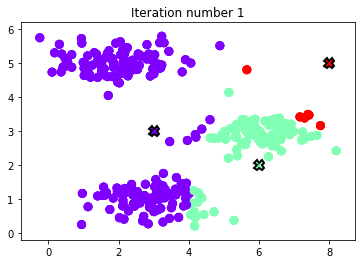

In [27]:
# Load an example dataset
data = loadmat(os.path.join('Data', 'ex7data2.mat'))

# Settings for running K-Means
K = 3
max_iters = 10

# For consistency, here we set centroids to specific values
# but in practice you want to generate them automatically, such as by
# settings them to be random examples (as can be seen in
# kMeansInitCentroids).
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])


# Run K-Means algorithm. The 'true' at the end tells our function to plot
# the progress of K-Means
centroids, idx, anim = runkMeans(X, initial_centroids,
                                       findClosestCentroids, computeCentroids, max_iters, True)
anim

The initial assignments of centroids for the previous dataset were predetermined. However, in practice a good strategy for initializing the centroids is to select random examples from the training set. We will now create a function to do just that. 

In [28]:
def kMeansInitCentroids(X, K):
    """
    This function initializes K centroids that are to be used in K-means on the dataset x.
    
    Parameters
    ----------
    X : array_like 
        The dataset of size (m x n).
    
    K : int
        The number of clusters.
    
    Returns
    -------
    centroids : array_like
        Centroids of the clusters. This is a matrix of size (K x n).
    """
    m, n = X.shape
    centroids = np.zeros((K, n))

    # Initialize the centroids to be random examples

    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])
    # Take the first K examples as centroids
    centroids = X[randidx[:K], :]

    return centroids

In this exercise, you will apply K-means to image compression. We will use the image below as an example (property of Frank Wouters with permission to this class).

![](Data/bird_small.png)
In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often referred to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, we will reduce the number of colors to 16 colors.

By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, we only need to store the RGB values of the 16 selected colors, and for each pixel in the image we now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In this exercise, we will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, we will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once we have computed the cluster centroids on the image, we will then use the 16 colors to replace the pixels in the original image.

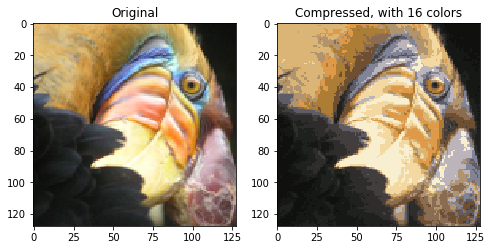

In [30]:
# ======= Experiment with these parameters ================
# We can try different values for these parameters
K = 16
max_iters = 10

# Load an image of a bird
# Any png image can be read in here
A = mpl.image.imread(os.path.join('Data', 'bird_small.png'))
# ==========================================================

# Divide by 255 so that all values are in the range 0 - 1
A /= 255

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on.
X = A.reshape(-1, 3)

# When using K-Means, it is important to randomly initialize centroids
# You should complete the code in kMeansInitCentroids above before proceeding
initial_centroids = kMeansInitCentroids(X, K)

# Run K-Means
centroids, idx = runkMeans(X, initial_centroids,
                                 findClosestCentroids,
                                 computeCentroids,
                                 max_iters)

# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by its index in idx) to the centroid value
# Reshape the recovered image into proper dimensions
X_recovered = centroids[idx, :].reshape(A.shape)

# Display the original image, rescale back by 255
fig, ax = pyplot.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A*255)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255
ax[1].imshow(X_recovered*255)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)

<h3>2 Principal Component Analysis</h3>
In this exercise we will use principle component analysis (PCA) to perform dimensionality reduction. We will first experiment with an example 2D dataset to get intuition on how PCA works, then use it on a bigger dataset of 5000 face images.

The following cell will plot the 2D training data. In this part of the exercise we will visualize what happens as we use PCA to reduce data from 2D to 1D. 

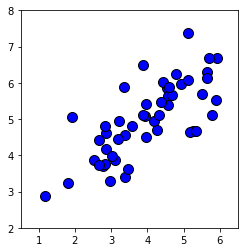

In [31]:
# Load the dataset into the variable X 
data = loadmat(os.path.join('Data', 'ex7data1.mat'))
X = data['X']

#  Visualize the example dataset
pyplot.plot(X[:, 0], X[:, 1], 'bo', ms=10, mec='k', mew=1)
pyplot.axis([0.5, 6.5, 2, 8])
pyplot.gca().set_aspect('equal')
pyplot.grid(False)

We will now implement PCA. This consists of two steps: First, we compute the covariance matrix of the data. Then we use the SVD function to compute the eigenvectors. These will correspond to the principle components of variation in the data. 

Before using PCA, it is importan to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range. After doing so we can run PCA and plot the corrosponding principle components. 

In [33]:
def pca(X):
    """
    Run principal component analysis.
    
    Parameters
    ----------
    X : array_like
        The dataset to be used for computing PCA. It has dimensions (m x n)
        where m is the number of examples (observations) and n is 
        the number of features.
    
    Returns
    -------
    U : array_like
        The eigenvectors, representing the computed principal components
        of X. U has dimensions (n x n) where each column is a single 
        principal component.
    
    S : array_like
        A vector of size n, contaning the singular values for each
        principal component. Note this is the diagonal of the matrix we 
        mentioned in class.
    """
    # Useful values
    m, n = X.shape
    
    U = np.zeros(n)
    S = np.zeros(n)

    X_trans = X.transpose()
    Sigma = (1/m)*(X_trans.dot(X))
    U, S, V = np.linalg.svd(Sigma)

    return U, S

In [36]:
def featureNormalize(X):
    """
    Normalizes the features in X returns a normalized version of X where the mean value of each
    feature is 0 and the standard deviation is 1. This is often a good preprocessing step to do when
    working with learning algorithms.

    Parameters
    ----------
    X : array_like
        An dataset which is a (m x n) matrix, where m is the number of examples,
        and n is the number of dimensions for each example.

    Returns
    -------
    X_norm : array_like
        The normalized input dataset.

    mu : array_like
        A vector of size n corresponding to the mean for each dimension across all examples.

    sigma : array_like
        A vector of size n corresponding to the standard deviations for each dimension across
        all examples.
    """
    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm /= sigma
    return X_norm, mu, sigma

Top eigenvector: U[:, 0] = [-0.707107 -0.707107]


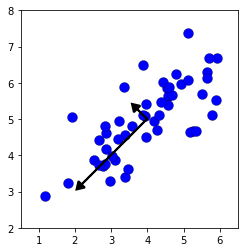

In [38]:
#  Before running PCA, it is important to first normalize X
X_norm, mu, sigma = featureNormalize(X)

#  Run PCA
U, S = pca(X_norm)

#  Draw the eigenvectors centered at mean of data. These lines show the
#  directions of maximum variations in the dataset.
fig, ax = pyplot.subplots()
ax.plot(X[:, 0], X[:, 1], 'bo', ms=10, mec='k', mew=0.25)

for i in range(2):
    ax.arrow(mu[0], mu[1], 1.5 * S[i]*U[0, i], 1.5 * S[i]*U[1, i],
             head_width=0.25, head_length=0.2, fc='k', ec='k', lw=2, zorder=1000)

ax.axis([0.5, 6.5, 2, 8])
ax.set_aspect('equal')
ax.grid(False)

print('Top eigenvector: U[:, 0] = [{:.6f} {:.6f}]'.format(U[0, 0], U[1, 0]))

After computing the principal components, we can use them to reduce the feature dimension of our dataset by projecting each example onto a lower dimensional space. In this part of the exercise, we will use the eigenvectors to project our dataset onto a 1-dimensional space. 

In [39]:
def projectData(X, U, K):
    """
    Computes the reduced data representation when projecting only 
    on to the top K eigenvectors.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). The dataset is assumed to be 
        normalized.
    
    U : array_like
        The computed eigenvectors using PCA. This is a matrix of 
        shape (n x n). Each column in the matrix represents a single
        eigenvector (or a single principal component).
    
    K : int
        Number of dimensions to project onto. Must be smaller than n.
    
    Returns
    -------
    Z : array_like
        The projects of the dataset onto the top K eigenvectors. 
        This will be a matrix of shape (m x k).
    """
    Z = np.zeros((X.shape[0], K))
    m = X.shape[0]

    for i in range(m):
        for j in range(K):
            x = X[i, :].transpose()
            Z[i,j] = np.dot(x.transpose(),  U[:, j])

    return Z

The following cell will test our function by projecting the first example onto the first dimension

In [41]:
#  Project the data onto K = 1 dimension
K = 1
Z = projectData(X_norm, U, K)
print('Projection of the first example: {:.6f}'.format(Z[0, 0]))

Projection of the first example: 1.481274


After projecting the data onto the lower dimensional space, we can appoximately recover the data by projecting them back onto the original high dimensional space. We will do so for the first example we saw and create a figure to visualize the process.

In [42]:
def recoverData(Z, U, K):
    """
    Recovers an approximation of the original data when using the 
    projected data.
    
    Parameters
    ----------
    Z : array_like
        The reduced data after applying PCA. This is a matrix
        of shape (m x K).
    
    U : array_like
        The eigenvectors (principal components) computed by PCA.
        This is a matrix of shape (n x n) where each column represents
        a single eigenvector.
    
    K : int
        The number of principal components retained
        (should be less than n).
    
    Returns
    -------
    X_rec : array_like
        The recovered data after transformation back to the original 
        dataset space. This is a matrix of shape (m x n), where m is 
        the number of examples and n is the dimensions (number of
        features) of original datatset.
    """
    X_rec = np.zeros((Z.shape[0], U.shape[0]))
    m, n = X.shape

    for i in range(m):
        for j in range(n):
            v = Z[i,:]
            X_rec[i,j] = np.dot(v, U[j, :K])

    # =============================================================
    return X_rec

Approximation of the first example: [-1.047419 -1.047419]


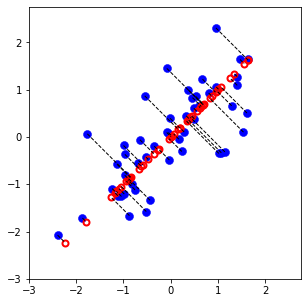

In [44]:
X_rec  = recoverData(Z, U, K)
print('Approximation of the first example: [{:.6f} {:.6f}]'.format(X_rec[0, 0], X_rec[0, 1]))

#  Plot the normalized dataset (returned from featureNormalize)
fig, ax = pyplot.subplots(figsize=(5, 5))
ax.plot(X_norm[:, 0], X_norm[:, 1], 'bo', ms=8, mec='b', mew=0.5)
ax.set_aspect('equal')
ax.grid(False)
pyplot.axis([-3, 2.75, -3, 2.75])

# Draw lines connecting the projected points to the original points
ax.plot(X_rec[:, 0], X_rec[:, 1], 'ro', mec='r', mew=2, mfc='none')
for xnorm, xrec in zip(X_norm, X_rec):
    ax.plot([xnorm[0], xrec[0]], [xnorm[1], xrec[1]], '--k', lw=1)

We will now run PCA on face images to see how it can be used in practice for dimension reduction. We have a dataset of face images, each 32 x 32 in grayscale. The following cells will load and visualize the first 100 of these face images.

In [47]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data in a nice grid.

    Parameters
    ----------
    X : array_like
        The input data of size (m x n) where m is the number of examples and n is the number of
        features.

    example_width : int, optional
        THe width of each 2-D image in pixels. If not provided, the image is assumed to be square,
        and the width is the floor of the square root of total number of pixels.

    figsize : tuple, optional
        A 2-element tuple indicating the width and height of figure in inches.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = int(n / example_width)

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_height, example_width, order='F'), cmap='gray')
        ax.axis('off')

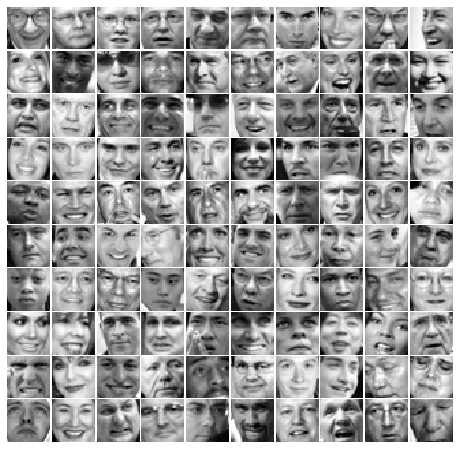

In [48]:
#  Load Face dataset
data = loadmat(os.path.join('Data', 'ex7faces.mat'))
X = data['X']

#  Display the first 100 faces in the dataset
displayData(X[:100, :], figsize=(8, 8))

To run PCA on the face dataset, we first normalize the dataset by subtracting the mean of each feature from the data matrix X. After running PCA we visualize the principal components by reshaping each into a 32 x 32 matrix that corrosponds to the pixels in the original dataset. 

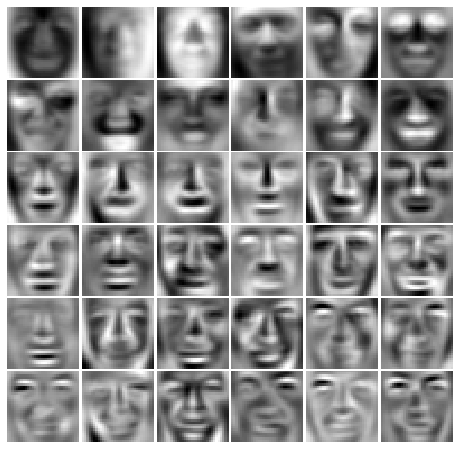

In [51]:
#  normalize X by subtracting the mean value from each feature
X_norm, mu, sigma = featureNormalize(X)

#  Run PCA
U, S = pca(X_norm)

#  Visualize the top 36 eigenvectors found
displayData(U[:, :36].T, figsize=(8, 8))

Now that we have the principle components, we can use them to reduce the dimension of the face dataset. This allows us to use our learning algorithm with a smaller input size, helping to speed it up. The following cell will project the face dataset onto only the first 100 principle components. 

In [52]:
#  Project images to the eigen space using the top k eigenvectors 
#  If you are applying a machine learning algorithm 
K = 100
Z = projectData(X_norm, U, K)

print('The projected data Z has a shape of: ', Z.shape)

The projected data Z has a shape of:  (5000, 100)


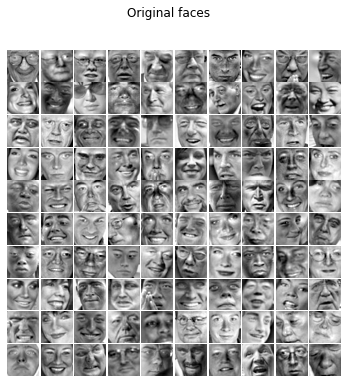

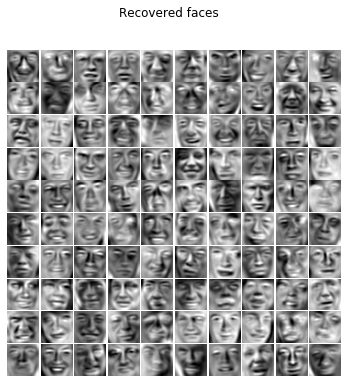

In [54]:
#  Project images to the eigen space using the top K eigen vectors and 
#  visualize only using those K dimensions
#  Compare to the original input, which is also displayed
K = 100
X_rec  = recoverData(Z, U, K)

# Display normalized data
displayData(X_norm[:100, :], figsize=(6, 6))
pyplot.gcf().suptitle('Original faces')

# Display reconstructed data from only k eigenfaces
displayData(X_rec[:100, :], figsize=(6, 6))
pyplot.gcf().suptitle('Recovered faces')
pass